# Projet 6 - Classifiez automatiquement des biens de consommation

But de la mission : étudier la faisabilité d'un moteur de classification des articles en différentes catégories

Problèmes :

Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre :

- deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).

Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :

- un algorithme de type SIFT / ORB / SURF ;
- un algorithme de type CNN Transfer Learning.

Etapes demandées :

- analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images
- une réduction de dimension
- un clustering

# Installation

In [1]:
pip install wordcloud

In [2]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow-hub

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install load_img

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement load_img (from versions: none)
ERROR: No matching distribution found for load_img


In [8]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


# Importations des librairies

In [9]:
# Import des librairies
import numpy as np
import pandas as pd
import string
from collections import Counter
import time

# Gestion des graphiques
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, LancasterStemmer

from gensim.models.word2vec import Word2Vec

from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.cluster import adjusted_rand_score

# Algo CNN Transfert Learning
#from keras.preprocessing import image_utils
from keras.utils import image_utils
from keras.utils import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
from keras import Model

# Algo SIFT
import cv2

# disable WARNING, INFO and DEBUG logging everywhere
import logging
logging.disable(logging.WARNING)
 

# Paramétrages

In [10]:
# Format des résultats affichés
pd.set_option('display.max_columns', None) # display.max_columns : contrôle le nombre de colonnes à imprimer
pd.set_option('max_colwidth', 100) # Vous pouvez augmenter la largeur en passant un int
pd.set_option("display.max_rows", 100) # Pour modifier le nombre de lignes, vous devez modifier l' option max_rows 
pd.options.display.float_format = '{:.4f}'.format # enlève le format d'affichage : nombre scientifique

# Pour afficher les graphiques dans la continuité du code, et non pas dans une fenêtre à part:
%matplotlib inline

# ignore les warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
df = pd.read_csv('C:/Users/qingdaohaishengxin/Desktop/openclassroom/Projet 6/Flipkart/flipkart_com-ecommerce_sample_1050.csv',encoding='ISO-8859-1')

In [12]:
path = "C:/Users/qingdaohaishengxin/Desktop/openclassroom/Projet 6/Flipkart/Images/"

In [13]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,009099b1f6e1e8f893ec29a7023153c4,2016-04-24 18:34:50 +0000,http://www.flipkart.com/palito-plo-166-analog-watch-girls-women/p/itmehzpfg7n2r4sf?pid=WATEHZPFA...,"palito PLO 166 Analog Watch - For Girls, Women","[""Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 166 Analog Watch - For Girls, ...",WATEHZPFAPQKUASQ,1500,199,009099b1f6e1e8f893ec29a7023153c4.jpg,False,"Specifications of palito PLO 166 Analog Watch - For Girls, Women General Type Analog Style Code...",No rating available,No rating available,palito,"{""product_specification""=>[{""key""=>""Type"", ""value""=>""Analog""}, {""key""=>""Style Code"", ""value""=>""P..."
1,0096e89cc25a8b96fb9808716406fe94,2016-06-17 14:13:36 +0000,http://www.flipkart.com/oxford-tawa-15-cm-diameter/p/itmejqr9e5a58yvz?pid=PTPEJQR9VKFUV4HY,oxford Tawa 15 cm cm diameter,"[""Kitchen & Dining >> Cookware >> Pots & Pans >> Pans & Tawas >> oxford Pans & Tawas >> oxford T...",PTPEJQR9VKFUV4HY,699,659,0096e89cc25a8b96fb9808716406fe94.jpg,False,"Key Features of oxford Tawa 15 cm cm diameter Non-stick Tawa,Specifications of oxford Tawa 15 cm...",No rating available,No rating available,oxford,"{""product_specification""=>[{""key""=>""Pan Type"", ""value""=>""Flat""}, {""key""=>""Non-stick"", ""value""=>""..."
2,00cbbc837d340fa163d11e169fbdb952,2016-01-01 19:37:22 +0000,http://www.flipkart.com/flazee-home-trends-beige-144-78-cm-table-runner/p/itme8gr3d6tdghqa?pid=T...,Flazee Home Trends Beige 144.78 cm Table Runner,"[""Home Furnishing >> Kitchen & Dining Linen >> Table Runners""]",TBRE8GR3RSTQTXMJ,1299,399,00cbbc837d340fa163d11e169fbdb952.jpg,False,Buy Flazee Home Trends Beige 144.78 cm Table Runner at Rs. 399 at Flipkart.com. Only Genuine Pro...,No rating available,No rating available,Flazee Home Trends,"{""product_specification""=>[{""key""=>""Shape"", ""value""=>""Rectangle""}, {""key""=>""Brand"", ""value""=>""Fl..."
3,00d84a518e0550612fcfcba3b02b6255,2015-12-12 11:46:53 +0000,http://www.flipkart.com/mxofere-combo-rose-soap-aloevera-lemon-facewash-kit/p/itmebva8ht9jyq6w?p...,Mxofere Combo Rose Soap And Aloevera Lemon Facewash Kit,"[""Beauty and Personal Care >> Combos and Kits >> Mxofere Combos and Kits""]",CBKEBVA8PUFUPRW4,285,285,00d84a518e0550612fcfcba3b02b6255.jpg,False,Buy Mxofere Combo Rose Soap And Aloevera Lemon Facewash Kit for Rs.285 online. Mxofere Combo Ros...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Organic Type"", ""value""=>""Natural""}, {""key""=>""Number of Conte..."
4,00e966a5049a262cfc72e6bbf68b80e7,2016-06-17 07:53:02 +0000,http://www.flipkart.com/ygs-keyboard-case-asus-memo-pad-7in-tab/p/itmejgh6yassufdt?pid=ACCEJGH6J...,YGS Keyboard Case for Asus Memo Pad 7in Tab,"[""Computers >> Tablet Accessories >> Cases & Covers >> YGS Cases & Covers >> YGS Keyboard Case f...",ACCEJGH6JVTM4CBH,1000,499,00e966a5049a262cfc72e6bbf68b80e7.jpg,False,Key Features of YGS Keyboard Case for Asus Memo Pad 7in Tab Portfolio Folio Case with Magnetic l...,No rating available,No rating available,YGS,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""YGS""}, {""key""=>""Shade"", ""value""=>""Pink""}, ..."


# Doublons et valeurs manquantes

In [14]:
df.loc[df['product_rating'] == 'No rating available', 'product_rating'] = np.nan
df.loc[df['overall_rating'] == 'No rating available', 'overall_rating'] = np.nan

In [15]:
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df.shape[0],df.shape[1]).replace(',',' '))

Il y a 250 lignes dans le df et 15 colonnes.


In [16]:
print('Il y a {} doublons.'.format(df.duplicated(subset=['uniq_id']).sum()))

Il y a 0 doublons.


In [17]:
print('Il y a {} doublons.'.format(df.duplicated(subset=['product_name']).sum()))

Il y a 0 doublons.


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   uniq_id                  250 non-null    object
 1   crawl_timestamp          250 non-null    object
 2   product_url              250 non-null    object
 3   product_name             250 non-null    object
 4   product_category_tree    250 non-null    object
 5   pid                      250 non-null    object
 6   retail_price             250 non-null    int64 
 7   discounted_price         250 non-null    int64 
 8   image                    250 non-null    object
 9   is_FK_Advantage_product  250 non-null    bool  
 10  description              250 non-null    object
 11  product_rating           36 non-null     object
 12  overall_rating           36 non-null     object
 13  brand                    170 non-null    object
 14  product_specifications   250 non-null    o

Beaucoup d'informations concernant les produits, mais seul quelques informations nous intéresse:

- son identifiant (pour les différencier) ==> uniq_id
- leur catégorie (pour avoir les vrais valeurs à trouver) ==> product_category_tree
- leur description ==> description
- leur image ==> image

De plus, il n'y a aucune valeur manquantes dans les données.

# Filtrage des colonnes

In [19]:
df = df[['uniq_id', 'product_category_tree', 'image', 'description']]
df

,uniq_id,product_category_tree,image,description
0,009099b1f6e1e8f893ec29a7023153c4,"[""Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 166 Analog Watch - For Girls, ...",009099b1f6e1e8f893ec29a7023153c4.jpg,"Specifications of palito PLO 166 Analog Watch - For Girls, Women General Type Analog Style Code..."
1,0096e89cc25a8b96fb9808716406fe94,"[""Kitchen & Dining >> Cookware >> Pots & Pans >> Pans & Tawas >> oxford Pans & Tawas >> oxford T...",0096e89cc25a8b96fb9808716406fe94.jpg,"Key Features of oxford Tawa 15 cm cm diameter Non-stick Tawa,Specifications of oxford Tawa 15 cm..."
2,00cbbc837d340fa163d11e169fbdb952,"[""Home Furnishing >> Kitchen & Dining Linen >> Table Runners""]",00cbbc837d340fa163d11e169fbdb952.jpg,Buy Flazee Home Trends Beige 144.78 cm Table Runner at Rs. 399 at Flipkart.com. Only Genuine Pro...
3,00d84a518e0550612fcfcba3b02b6255,"[""Beauty and Personal Care >> Combos and Kits >> Mxofere Combos and Kits""]",00d84a518e0550612fcfcba3b02b6255.jpg,Buy Mxofere Combo Rose Soap And Aloevera Lemon Facewash Kit for Rs.285 online. Mxofere Combo Ros...
4,00e966a5049a262cfc72e6bbf68b80e7,"[""Computers >> Tablet Accessories >> Cases & Covers >> YGS Cases & Covers >> YGS Keyboard Case f...",00e966a5049a262cfc72e6bbf68b80e7.jpg,Key Features of YGS Keyboard Case for Asus Memo Pad 7in Tab Portfolio Folio Case with Magnetic l...
...,...,...,...,...
245,40efb9474b44fba54b5d2a8df121d727,"[""Watches >> Wrist Watches >> Sonata Wrist Watches""]",40efb9474b44fba54b5d2a8df121d727.jpg,Sonata 7007YL08 Watch - Buy Sonata 7007YL08 Watch 7007YL08 Online at Rs.849 in India Only at Fl...
246,412d0425bb7076610aace6549ded265c,"[""Home Decor & Festive Needs >> Showpieces >> Ethnic >> Lal Haveli Ethnic""]",412d0425bb7076610aace6549ded265c.jpg,Lal Haveli Rajasthani Handmade Vintage Wooden Camel Design Jharoka Photo Frame Showpiece - 43....
247,41384da51732c0b4df3de8f395714fbb,"[""Watches >> Wrist Watches >> Alfajr Wrist Watches""]",41384da51732c0b4df3de8f395714fbb.jpg,"Alfajr WY16B Youth Digital Watch - For Men, Boys - Buy Alfajr WY16B Youth Digital Watch - For ..."
248,414d2065e1aed847064bcf14538eabc8,"[""Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars""]",414d2065e1aed847064bcf14538eabc8.jpg,Buy Raymond Abstract Double Blanket Blue at Rs. 4999 at Flipkart.com. Only Genuine Products. Fre...


In [20]:
df.describe(include = 'all')

,uniq_id,product_category_tree,image,description
count,250,250,250,250
unique,250,188,250,250
top,009099b1f6e1e8f893ec29a7023153c4,"[""Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars""]",009099b1f6e1e8f893ec29a7023153c4.jpg,"Specifications of palito PLO 166 Analog Watch - For Girls, Women General Type Analog Style Code..."
freq,1,10,1,1


La categorie du produit renvoie en vérité une hiérarchie de catégorie de produit. Je vais diviser cette donnée pour avoir les principales catégories.

# Catégorie du produit

In [21]:
# je transforme en list cette donnée
df_temp = df.product_category_tree.str.replace('["','', regex = False
                                    ).str.replace('"]','', regex = False
                                                 ).str.split(' >> ', expand = True)
# je ne garde que les premières catégories les plus remplies
df_temp = df_temp.loc[:,df_temp.isna().sum() < 10]

# je créé la list des noms des colonnes de catégories de produit gardées
idx = []
for i in range(0,df_temp.shape[1]):
    idx.append('product_category_'+str(i+1))
    
# je transforme le nom des colonnes
df_temp.columns = idx

# j'ajoute ce df temporaire au df principal
df = pd.concat([df,df_temp], axis = 1)
del df_temp, idx
df.drop(columns = ['product_category_tree'], inplace = True)
df.head()

,uniq_id,image,description,product_category_1,product_category_2,product_category_3
0,009099b1f6e1e8f893ec29a7023153c4,009099b1f6e1e8f893ec29a7023153c4.jpg,"Specifications of palito PLO 166 Analog Watch - For Girls, Women General Type Analog Style Code...",Watches,Wrist Watches,palito Wrist Watches
1,0096e89cc25a8b96fb9808716406fe94,0096e89cc25a8b96fb9808716406fe94.jpg,"Key Features of oxford Tawa 15 cm cm diameter Non-stick Tawa,Specifications of oxford Tawa 15 cm...",Kitchen & Dining,Cookware,Pots & Pans
2,00cbbc837d340fa163d11e169fbdb952,00cbbc837d340fa163d11e169fbdb952.jpg,Buy Flazee Home Trends Beige 144.78 cm Table Runner at Rs. 399 at Flipkart.com. Only Genuine Pro...,Home Furnishing,Kitchen & Dining Linen,Table Runners
3,00d84a518e0550612fcfcba3b02b6255,00d84a518e0550612fcfcba3b02b6255.jpg,Buy Mxofere Combo Rose Soap And Aloevera Lemon Facewash Kit for Rs.285 online. Mxofere Combo Ros...,Beauty and Personal Care,Combos and Kits,Mxofere Combos and Kits
4,00e966a5049a262cfc72e6bbf68b80e7,00e966a5049a262cfc72e6bbf68b80e7.jpg,Key Features of YGS Keyboard Case for Asus Memo Pad 7in Tab Portfolio Folio Case with Magnetic l...,Computers,Tablet Accessories,Cases & Covers


In [22]:
listColCat = df.columns.tolist()
listColCat = [x for x in listColCat if 'product_category' in x]
listColCat

['product_category_1', 'product_category_2', 'product_category_3']

Maintenant que j'ai bien séparer ma hiérarchie de catégorie de produit, il faut que j'en choisisse une seule pour construire ma classification.Je vais regarder du côté des modalités, valeurs uniques.

In [23]:
for var in listColCat:
    print(var,':',df[var].isna().sum(),'ligne(s) vide(s) ;',df[var].nunique(),'modalités.')

product_category_1 : 0 ligne(s) vide(s) ; 7 modalités.
product_category_2 : 0 ligne(s) vide(s) ; 43 modalités.
product_category_3 : 2 ligne(s) vide(s) ; 101 modalités.


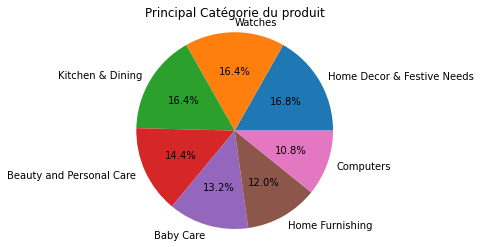

In [24]:
df["product_category_1"].value_counts(normalize=True).plot(kind = 'pie', autopct = '%1.1f%%', label = '')
plt.axis('equal')
plt.title('Principal Catégorie du produit')
plt.show();

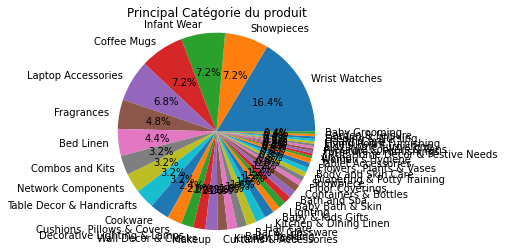

In [25]:
df["product_category_2"].value_counts(normalize=True).plot(kind = 'pie', autopct = '%1.1f%%', label = '')
plt.axis('equal')
plt.title('Principal Catégorie du produit')
plt.show();

En plus de comprendre moins de catégorie de produit, elle est proportionnellement représentée entre toutes ses modalités. Je vais donc choisir la principale catégorie de produit, product_category_1, pour ma classification.

In [26]:
df = df.drop(columns = listColCat[1:])
df = df.rename(columns = {listColCat[0]:'product_category'})
df.head()

,uniq_id,image,description,product_category
0,009099b1f6e1e8f893ec29a7023153c4,009099b1f6e1e8f893ec29a7023153c4.jpg,"Specifications of palito PLO 166 Analog Watch - For Girls, Women General Type Analog Style Code...",Watches
1,0096e89cc25a8b96fb9808716406fe94,0096e89cc25a8b96fb9808716406fe94.jpg,"Key Features of oxford Tawa 15 cm cm diameter Non-stick Tawa,Specifications of oxford Tawa 15 cm...",Kitchen & Dining
2,00cbbc837d340fa163d11e169fbdb952,00cbbc837d340fa163d11e169fbdb952.jpg,Buy Flazee Home Trends Beige 144.78 cm Table Runner at Rs. 399 at Flipkart.com. Only Genuine Pro...,Home Furnishing
3,00d84a518e0550612fcfcba3b02b6255,00d84a518e0550612fcfcba3b02b6255.jpg,Buy Mxofere Combo Rose Soap And Aloevera Lemon Facewash Kit for Rs.285 online. Mxofere Combo Ros...,Beauty and Personal Care
4,00e966a5049a262cfc72e6bbf68b80e7,00e966a5049a262cfc72e6bbf68b80e7.jpg,Key Features of YGS Keyboard Case for Asus Memo Pad 7in Tab Portfolio Folio Case with Magnetic l...,Computers


Je dois maintenant passer au nettoyage de mes features sur lesquelles mon modèle va se baser pour prédire la catégorie du produit : la description et l'image du produit.

## Description du produit

Pour cela, je vais appliquer plusieurs transformations :

- je vais d'abord mettre toutes les descriptions en minuscule et leur supprimer tout ce qui n'est pas du texte (les ponctuations, les chiffres)
- je vais ensuite transformer le texte en liste de mots
- de ces listes, je vais supprimer tout ce qui n'est pas informatif (stopword, mots courts, ...)
- je vais transformer les mots restant de sorte à ne garder que leur forme pure (infinitif des verbes, racine des noms, ...)
- enfin, je vais supprimer les mots apparaissant dans moins de 1% ou plus de 80% des descriptions produits.

In [27]:
def prep_control(series):
    if isinstance(series.iloc[0], list):
        series_join = series.apply(lambda x: ' '.join([item for item in x]))
        all_words = ' '.join(sorted([word for word in series_join]))
        vocab = sorted(np.unique(all_words.split(' ')))
        print('---------')
        print('Il y a {} mots différents dans les descriptions.'.format(len(vocab)))
        indexes = np.unique(series.iloc[0], return_index = True)[1]
        example = [series.iloc[0][index] for index in sorted(indexes)]
        print('Sentence example :', example)
        print('---------')
    else:
        all_words = ' '.join(sorted([word for word in series]))
        vocab = sorted(np.unique(all_words.split(' ')))
        print('Il y a {} mots différents dans les descriptions.'.format(len(vocab)))
        print('Sentence example :', series.iloc[0])

def prep_cleaning(series):
    
    print('Cleaning in progress ...')
    
    # lower case
    series = series.str.lower()
    # delete punctuation
    series = series.str.translate({ord(x): ' ' for x in list(string.punctuation)})
    # delete extra space
    series = series.str.replace('\s\s', ' ', regex = True)
    # delete number
    series = series.str.replace('[a-z]*[0-9]', '', regex = True)
    # delete extra space
    series = series.str.replace('\s\s', ' ', regex = True)
    
    print('... finished')
    print('---------')
    
    prep_control(series)
    
    return series

def prep_token(series):
    
    print('Tokenizer in progress ...')
    
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    series = series.apply(tokenizer.tokenize)
    
    print('... finished')
    print('---------')
    
    prep_control(series)
    
    return series

def prep_stopWords(series):    # suppression des mots sans valeur informative (de, a, comme, ...)
    
    print('Delete stop words in progress ...')
    
    stopwords = nltk.corpus.stopwords.words("english")
    series = series.apply(lambda x: [item for item in x if item not in stopwords])
    
    print('... finished')
    print('---------')
    
    prep_control(series)
    
    return series

def prep_minWords(series, minLengthWord): # suppression des mots dont la longueur fait moins que minLengthWord
    
    print('Delete short words in progress ...')
    
    series = series.apply(lambda x: [item for item in x if len(item) >= minLengthWord])
    
    print('... finished')
    print('---------')
    
    prep_control(series)
    
    return series

def prep_get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def prep_lemStem(series, method = 'lem'):
    
    if method == 'lem':
    
        print('Lemmatization in progress ...')
        
        wordnetlem = WordNetLemmatizer()
        series = series.apply(lambda x: [wordnetlem.lemmatize(item, prep_get_wordnet_pos(item)) for item in x])
        
    else:
        print('Stemming in progress ...')
        
        lancaster = LancasterStemmer()
        series = series.apply(lambda x: [lancaster.stem(item) for item in x])
    
    print('... finished')
    print('---------')
    
    prep_control(series)
    
    return series

def prep_minmaxFreqWords(series, minF, maxF):
    
    print('Delete infrequent and too frequent words in progress ...')
    
    series_join = series.apply(lambda x: ' '.join([item for item in x]))
    all_words = ' '.join(sorted([word for word in series_join]))
    
    word_list = all_words.split(' ')
    word_counts = Counter(word_list)
    
    max_freq = int(np.round(df.shape[0]*minF))
    min_freq = int(np.round(df.shape[0]*maxF))
    
    delete_word = [key for key, value in word_counts.items() if (value >= max_freq) or (value <= min_freq)]
    series = series.apply(lambda x: [item for item in x if not item in delete_word])
    
    print('... finished')
    print('---------')
    
    prep_control(series)
    
    return series

def preprocessing_desc(df_func, is_clean = True, is_token = True, is_stopwords = True, is_minword = True
                       , is_lemstem = True, lemstem_choice = 'lem'
                       , is_freqword = True, freq = [0.8, 0.01]):
    
    col = df_func.columns.to_list()
    col_desc = [x for x in col if 'desc' in x][0]
    
    if is_clean == True:
        prep_control(df_func[col_desc])
        # cleaning of sentences
        df_func[col_desc] = prep_cleaning(df_func[col_desc])

    if is_token == True:
        # tokenization
        df_func[col_desc+'_token'] = prep_token(df_func[col_desc])
        
    col_desc = col_desc + '_token'

    if is_stopwords == True:
        # delete stopwords
        df_func[col_desc] = prep_stopWords(df_func[col_desc])

    if is_lemstem == True:
        # Lemmatisation
        df_func[col_desc] = prep_lemStem(df_func[col_desc], lemstem_choice)

    if is_minword == True:
        # suppression des mots d'un seul caractère
        df_func[col_desc] = prep_minWords(df_func[col_desc], 2)

    if is_freqword == True:
        # suppression des mots apparaissant sur -1% ou +80% des lignes
        df_func[col_desc] = prep_minmaxFreqWords(df_func[col_desc].copy(), freq[0], freq[1])
    
    # affichage du nuage de mots
    df_func['desc_join'] = df_func[col_desc].apply(lambda x: ' '.join([item for item in x]))
    all_words = ' '.join(sorted([word for word in df_func['desc_join']]))
    wordcloud = WordCloud(width = 600
                          , height = 400
                          , random_state = 2
                          , max_font_size = 100
                         ).generate(all_words)

    plt.figure(figsize = (10, 7))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show();
    
    return df_func

In [28]:
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df.shape[0],df.shape[1]).replace(',',' '))
df.sample(10)

Il y a 250 lignes dans le df et 4 colonnes.


,uniq_id,image,description,product_category
217,3adb36e4275733d0d113d9039e6814ea,3adb36e4275733d0d113d9039e6814ea.jpg,"Vincent Valentine Paris Set of Dark Fire, Dark Fire & Majesty Deodorants Combo Set (Set of 3)\r\...",Beauty and Personal Care
222,3ba13df7877fd979d64c87c7586a5ca6,3ba13df7877fd979d64c87c7586a5ca6.jpg,Buy Arsalan 10.5 inch Glass Hookah for Rs.349 online. Arsalan 10.5 inch Glass Hookah at best pri...,Home Decor & Festive Needs
155,29d7a1b4d4f658fc3082905f65e1b009,29d7a1b4d4f658fc3082905f65e1b009.jpg,Flipkart.com is offering Small Funcart Frolic Birthday - Food Grade Plastic for only for Rs 154...,Baby Care
229,3cdfd9df09f61a8fd178bafcc8dbed31,3cdfd9df09f61a8fd178bafcc8dbed31.jpg,"HEAVENLY Dress Baby Boy's Combo Price: Rs. 590 REGULAR SMOOTH AND 100% COTTON WEAR,Specificatio...",Baby Care
127,23704dd51c975e845c574b044aae0a9f,23704dd51c975e845c574b044aae0a9f.jpg,Buy Equinox EB-EQ 33 Body Fat Analyzer only for Rs. 3292 from Flipkart.com. Only Genuine Product...,Beauty and Personal Care
140,26989e846c2096a5b59b59cbea2cc7ab,26989e846c2096a5b59b59cbea2cc7ab.jpg,Buy Tenda A6 only for Rs. 1800 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guar...,Computers
38,093bcad64d11c0aed903a8dd787ef069,093bcad64d11c0aed903a8dd787ef069.jpg,"Offspring Embroidered, Solid Single Wrapper White, Pink (1 Wrap)\r\n Pri...",Baby Care
138,2651ce313a5a3aedb7c566394a3b3b26,2651ce313a5a3aedb7c566394a3b3b26.jpg,"Key Features of Aster Luxury Arabic Oudh Bathing Bar - Pack of 4 SLES FREE: PHTHALATES FREE,Aste...",Beauty and Personal Care
99,198dbe7be6f84f6448197148d7b5e5a5,198dbe7be6f84f6448197148d7b5e5a5.jpg,Buy RoyalsCart KTH505 Showpiece - 33 cm for Rs.2499 online. RoyalsCart KTH505 Showpiece - 33...,Home Decor & Festive Needs
65,1120bc768623572513df956172ffefeb,1120bc768623572513df956172ffefeb.jpg,"Escort E-1700-906_Blk Analog Watch - For Men, Boys\r\n Price: Rs. 1,829...",Watches


# Features Texte

## Approche “bag-of-words” : comptage simple de mots

In [29]:
def featTxt_BOW_cs(df_func):
    
    desc_col = df_func.columns.tolist()
    desc_col = [x for x in desc_col if 'join' in x]
    corpus = df_func[desc_col].values.tolist()
    corpus = [x[0] for x in corpus]
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    matrice = X.todense()
    df_temp = pd.DataFrame(matrice, columns = vectorizer.get_feature_names_out())
    
    return df_temp

## Approche “bag-of-words” : Tf-idf

In [30]:
def featTxt_BOW_tfidf(df_func):
    
    desc_col = df_func.columns.tolist()
    desc_col = [x for x in desc_col if 'join' in x]
    corpus = df_func[desc_col].values.tolist()
    corpus = [x[0] for x in corpus]
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    matrice = X.todense()
    df_temp = pd.DataFrame(matrice, columns = vectorizer.get_feature_names_out())
    
    return df_temp

## Approche word/sentence embedding : Word2Vec

In [31]:
def featTxt_WE_w2v(df_func):
    # Gestion du df
    desc_col = df_func.columns.tolist()
    desc_col = [x for x in desc_col if 'join' in x]
    corpus = df_func[desc_col].values.tolist()
    corpus = [x[0] for x in corpus]
    
    # mise en place du modèle (vocabulaire, entrainement)
    w2v_size = 100
    vectorizer = Word2Vec(corpus
                          , min_count = 3   # Ignores all words with total frequency lower than this, default 5
                          , vector_size = w2v_size   # Dimensionality of word embeddings, default 100
                          , workers = 3     # Training parallelization, to speed up training, default 3
                          , sg = 1          # skipgrams
                          , window = 7      # Context window for words during training / Maximum distance between the current and predicted word within a sentence
                          , epochs = 50     # Number of epochs training over corpus
                         )
    model_vectors = vectorizer.wv              # the mapping between words and embeddings
    w2v_words = model_vectors.index_to_key
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    maxlen = max(len(x) for x in corpus)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(corpus)
                                , maxlen = maxlen
                                , padding = 'post')
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i = 0
    j = 0
    for word, idx in word_index.items():
        i += 1
        if word in w2v_words:
            j += 1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
    word_rate = np.round(j/i,4)
    # modèle CBOW
    input = Input(shape = (len(x_sentences),maxlen), dtype = 'float64')
    word_input = Input(shape = (maxlen,), dtype = 'float64')
    '''
    La couche Embedding va transformer chaque mot du contexte en vecteur d’embedding. 
    La matrice W de l’embedding sera apprise au fur et à mesure que le modèle s’entraîne. 
    Les dimensions résultantes sont : (lot, context_size, embedding).
    '''
    word_embedding = Embedding(input_dim = vocab_size
                               , output_dim = w2v_size
                               , weights = [embedding_matrix]
                               , input_length = maxlen)(word_input)
    '''
    La couche GlobalAveragePooling1D permet de sommer les différents embedding pour avoir une dimension en sortie 
    (batch_size, embedding).
    '''
    word_vec = GlobalAveragePooling1D()(word_embedding) 
    embed_model = Model([word_input], word_vec)
    embeddings = embed_model.predict(x_sentences)
    
    df_temp = pd.DataFrame(embeddings, columns = range(0,embeddings.shape[1]))
    
    return df_temp

## Approche word/sentence embedding : BERT

In [32]:
def featTxt_WE_bert(df_func):
    
    # Gestion du df
    desc_col = df_func.columns.tolist()
    desc_col = [x for x in desc_col if 'token' in x]
    corpus = df_func[desc_col].values.tolist()
    corpus = [x[0] for x in corpus]
    
    batch_size = 10
    max_length = 64
    model_type = 'bert-base-uncased'
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    model = TFAutoModel.from_pretrained(model_type)

    for step in range(len(corpus)//batch_size) :
        idx = step*batch_size
        
        input_ids = []
        token_type_ids = []
        attention_mask = []

        for sent in corpus[idx:idx+batch_size]:
            bert_inp = bert_tokenizer.encode_plus(sent,
                                                  add_special_tokens = True,
                                                  max_length = max_length,
                                                  padding = 'max_length',
                                                  return_attention_mask = True, 
                                                  return_token_type_ids = True,
                                                  truncation = True,
                                                  return_tensors = "tf",
                                                  is_split_into_words = True)

            input_ids.append(bert_inp['input_ids'][0])
            token_type_ids.append(bert_inp['token_type_ids'][0])
            attention_mask.append(bert_inp['attention_mask'][0])

        input_ids = np.asarray(input_ids)
        token_type_ids = np.asarray(token_type_ids)
        attention_mask = np.array(attention_mask)
        
        text_preprocessed = {"input_ids" : input_ids, 
                             "attention_mask" : attention_mask, 
                             "token_type_ids" : token_type_ids}
        outputs = model(text_preprocessed)
        last_hidden_states = outputs[0]
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
     
    return pd.DataFrame(features_bert)

## Approche word/sentence embedding : USE (Universal Sentence Encoder) 

In [33]:
def featTxt_WE_use(df_func):
    
    # Gestion du df
    desc_col = df_func.columns.tolist()
    desc_col = [x for x in desc_col if 'join' in x]
    corpus = df_func[desc_col].values.tolist()
    corpus = [x[0] for x in corpus]  
    
    #embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    embed = hub.load("C:/Users/qingdaohaishengxin/anaconda3/Lib")
    features = embed(corpus)
    df_func = pd.DataFrame(features)
    
    return df_func

# Features Image

## Algorithme SIFT 

In [34]:
def featImg_SIFT(df_img, path):
    sift = cv2.SIFT_create(500)
    
    sift_keypoints = []
    # Pour chaque image passage en gris, equalisation et détection des descripteurs
    for image_num in range(df_img['image'].nunique()):
        #print(image_num)
        pict_name = str(df_img.loc[df_img.index == image_num,'image'].values[0])
        image = cv2.imread(path+pict_name, 0) # convert in gray
        res = cv2.equalizeHist(image)                     # equalize image histogram
        del image
        kp, des = sift.detectAndCompute(res, None)
        del res
        sift_keypoints.append(des)
        del kp, des
    
    # liste de descripteurs par image : utilisée pour réaliser les histogrammes par image
    sift_keypoints_by_img = np.asarray(sift_keypoints)
    del sift_keypoints

    # liste de descripteurs pour l'ensemble des images : utilisé pour créer les clusters de descripteurs
    sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis = 0)

    # Clustering
    k = int(round(np.sqrt(len(sift_keypoints_all)),0))
    kmeans = MiniBatchKMeans(n_clusters = k, init_size = 3*k, random_state = 0)
    kmeans.fit(sift_keypoints_all)
    del k
    
    # Creation of a matrix of histograms
    hist_vectors = []

    # Pour chaque image
    for i, image_desc in enumerate(sift_keypoints_by_img) :
        # prédiction des numéros de cluster de chaque descripteur
        res = kmeans.predict(image_desc)
        # comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
        hist = np.zeros(len(kmeans.cluster_centers_))
        nb_des = len(image_desc)
        if nb_des==0 : print("problème histogramme image : ", i)
        for j in res:
            hist[j] += 1.0/nb_des
        
        hist_vectors.append(hist)                     # histogram is the feature vector

    im_features = pd.DataFrame(hist_vectors)
    del hist_vectors
    
    return im_features

## Algorithme CNN Transfer Learning 

In [35]:
def featImg_CNN(df_img, path):

    # load model
    model = VGG16()
    # remove the output layer
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

    pict_vectors = []
    for img_num in range(df_img['image'].nunique()):
        # Préparation des images
        pict_name = str(df_img.loc[df_img.index == img_num,'image'].values[0])
        #img = tf.keras.preprocessing.image.load_img(path+pict_name, target_size = (224, 224))  # Charger les images
        #img = tf.keras.preprocessing.image.img_to_array(img)  # Convertir en tableau numpy
        img = load_img(path+pict_name, target_size = (224, 224))  # Charger les images
        img = img_to_array(img)  # Convertir en tableau numpy
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
        img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

        y = model.predict(img)  # Prédire la classe de l'image (parmi les 1000 classes d'ImageNet)
        pict_vectors.append(y[0])

    im_features = pd.DataFrame(pict_vectors)

    return im_features

# Réduction de dimension

## ACP 

In [36]:
def redDim_acp(df_vect):
    
    # on garde tous les axes qui amène 99% de variance expliquée cumulée
    n_comp = 0.99
    
    X = df_vect.values
    names = df_vect.index # ou data_pca.index pour avoir les intitulés servant pour les afficher sur le nuage des individus
    features = df_vect.columns # sert pour afficher les labels des variables sur le cercle des corrélations
    
    # Centrage et Réduction
    X_scaled = StandardScaler().fit_transform(X)
    pca = decomposition.PCA(n_components = n_comp)
    pca.fit(X_scaled) # ou X dans le cas d'un centrage uniquement
    
    nb_axe = len(pca.explained_variance_ratio_)
    
    df_return = pd.DataFrame(pca.fit_transform(X_scaled), index = df.index, columns = ['F'+str(i+1) for i in range(nb_axe)])
    
    return df_return

## T-SNE 

In [37]:
def redDim_tsne(df, ACP = True):
    
    if ACP == True:
        df_red = redDim_acp(df)
    else:
        df_red = df
    
    tsne = TSNE(n_components = 2
                , perplexity = 30
                , n_iter = 2000
                , init='random'
                , learning_rate = 200
                , random_state = 42)
    
    X_tsne = pd.DataFrame(tsne.fit_transform(df_red), columns = ['tsne-2d-one','tsne-2d-two'])
    
    return X_tsne

def viz_TSNE(df, y):
    
    df['y'] = y
    
    plt.figure(figsize = (12,6))
    sns.scatterplot(x = 'tsne-2d-one'
                    , y = 'tsne-2d-two'
                    , hue = 'y'
                    , palette = sns.color_palette("hls", df['y'].nunique())
                    , data = df
                    , legend = "full"
                    , alpha = 0.3
                   )
    plt.show();

## Classification non supervisé (Clustering) : K-Means

In [38]:
def create_Features_Text(desc, feat_txt):
    
    # début du chronomètre
    time1 = time.time()
    
    ### FEATURES TEXT ###
    # je lance la base du preprocessing
    print('Pré-traitement')
    desc = preprocessing_desc(desc
                              , is_clean = True, is_token = True, is_stopwords = True, is_minword = True
                              , is_lemstem = True, lemstem_choice = 'lem', is_freqword = False)

    # enregistrement du temps (Initialisation du modèle + Base du preprocessing)
    timePrepDesc = time.time() - time1
    
    # saut de ligne
    print()
    
    # list des df créé
    list_df_feat = []
    
    # list des param "choice_ACP" de la réduction de dimension
    list_ACP = []
    
    # list des temps de traitement des preprocessing + approches
    list_time = []
    
    # pour chaque approche Features Text
    for funcTxt in feat_txt:
        
        # Je lance mes approches sur une copie du df pour ne pas le modifier
        name_new_df = 'df_'+funcTxt.split('_')[2]
        globals()[name_new_df] = desc.copy()
        list_df_feat.append(name_new_df)
            
        # je lance le chronomètre
        time1 = time.time()
        
        print('-------------------------')
        # je relance la fin du preprocessing uniquement pour les bag-of-words : seuil fréquence des mots
        if 'BOW' in funcTxt:
            df_temp_desc = preprocessing_desc(globals()[name_new_df]
                                              , is_clean = False, is_token = False, is_stopwords = False
                                              , is_minword = False, is_lemstem = False
                                              , is_freqword = True, freq = [0.8, 0.01])
            print('Approche Bag-of-word ({}) :'.format(funcTxt.split('_')[2]))
        else:
            print('Approche Word/Sentence Embedding ({}) :'.format(funcTxt.split('_')[2]))
            
        print('-------------------------')
            
        # je lance l'approche en cours
        globals()[name_new_df] = globals()[funcTxt](globals()[name_new_df])
        
        # j'affiche le nombre de features text
        print('Nb Features text avant réduction :', globals()[name_new_df].shape[1])

        
        if ('WE' in funcTxt):
            print('Réduction TSNE (sans ACP)')
            globals()[name_new_df] = redDim_tsne(globals()[name_new_df], ACP = False)
            list_ACP.append('(sans ACP)')
        else:
            print('Réduction TSNE (avec ACP)')
            globals()[name_new_df] = redDim_tsne(globals()[name_new_df])
            list_ACP.append('(avec ACP)')
        
        # j'enregistre le temps (approche features text [+ reste du preprocessing])
        timeTxt = (time.time() - time1) + timePrepDesc
        list_time.append(timeTxt)
        print("Temps de traitement :",timeTxt)
        print('-------------------------')
        
    return list_df_feat, list_ACP, list_time

def create_Features_Image(df_image, path, feat_pict):
      
    # list des df créé
    list_df_feat = []
    
    # list des param "choice_ACP" de la réduction de dimension
    list_ACP = []
    
    # list des temps de traitement des preprocessing + approches
    list_time = []
    
    for funcPic in feat_pict:

        print('-------------------------')
        print('Approche ({}) :'.format(funcPic.split('_')[1]))
        print('-------------------------')
        
        time1 = time.time()
        
        name_new_df = 'df_'+funcPic.split('_')[1]
        globals()[name_new_df] = globals()[funcPic](df_image, path)
        list_df_feat.append(name_new_df)
        
        # j'affiche le nombre de features text
        print('Nb Features text avant réduction :', globals()[name_new_df].shape[1])

        print('Réduction TSNE (avec ACP)')
        globals()[name_new_df] = redDim_tsne(globals()[name_new_df])
        list_ACP.append('(avec ACP)')

        timePict = time.time() - time1
        list_time.append(timePict)
        print('Temps de traitement :', timePict)
        print('-------------------------')
        
    return list_df_feat, list_ACP, list_time

In [39]:
def classif_KMeans(df_func, path, feat_txt, feat_pict, n_clus, df_resultats):
    
    col = df_func.columns.tolist()
    
    # séparation des variables texte et image
    df_desc = df_func[[x for x in col if 'desc' in x]].copy()
    df_pict = df_func[[x for x in col if 'image' in x]].copy()
    
    # enregistrement des vrais labels
    col_label = [x for x in col if 'category' in x][0]
    y_true = df_func[col_label].copy()

    # début du chronomètre
    time1 = time.time()
    
    # initialisation du modèle
    model = KMeans(n_clusters = n_clus
                   , n_init = 100
                   , random_state = 42
                  )
    
    # enregistrement du temps (Initialisation du modèle + Base du preprocessing)
    timePrepModel = time.time() - time1
    
    # création des features à partir des variables Txt + Img
    list_df_feat_T, list_ACP_T, list_time_T = create_Features_Text(df_desc, feat_txt)
    list_df_feat_I, list_ACP_I, list_time_I = create_Features_Image(df_pict, path, feat_pict)
    
    # gestion du traitement du modèle Img seul
    trait_Img = []
    
    # pour chaque approche Features Text
    for name_df_T in list_df_feat_T:
        
        index_T = list_df_feat_T.index(name_df_T)
        
        print('--------')
        print('........')
        print(' Approche Features Text : ',name_df_T.replace('df_',''))

        # début du chronomètre
        time1 = time.time()
        
        # Desc seulement
        model.fit_predict(globals()[name_df_T])
        viz_TSNE(globals()[name_df_T], pd.Series(list(model.labels_))) # affichage du graphique TSNE avec vrai label
        ARI = np.round(adjusted_rand_score(y_true, model.labels_),4)
        timeTot = np.round((time.time() - time1) + list_time_T[index_T], 0)
        print('-.-.- Var Desc -.-.-')
        print('ARI :', ARI)
        print('Time :', timeTot)
        df_row = pd.DataFrame(np.array([['KMeans', name_df_T.replace('df_',''), np.nan, list_ACP_T[index_T], timeTot, ARI]]
                                       , dtype = object)
                          , columns = ['Modèle','Feature Texte','Feature Picture','Reduction','Time','ARI'])
        df_resultats = pd.concat([df_resultats, df_row], join = 'outer', ignore_index = True)
        
        print('--------')
        print('........')
        
        for name_df_I in list_df_feat_I:
        
            index_I = list_df_feat_I.index(name_df_I)
            
            if name_df_I.replace('df_','') not in trait_Img:
                print('--------')
                print('........')
                print(' Approche Features Image : ',name_df_I.replace('df_',''))
                
                # Image seulement
                time1 = time.time()
                model.fit_predict(globals()[name_df_I])
                viz_TSNE(globals()[name_df_I], pd.Series(list(model.labels_))) # affichage du graphique TSNE avec vrai label
                ARI = np.round(adjusted_rand_score(y_true, model.labels_),4)
                timeTot = np.round((time.time() - time1) + list_time_I[index_I], 0)
                print('-.-.- Var Image -.-.-')
                print('ARI :', ARI)
                print('Time :', timeTot)
                df_row = pd.DataFrame(np.array([['KMeans', np.nan, name_df_I.replace('df_','')
                                                 , list_ACP_I[index_I], timeTot, ARI]]
                                               , dtype = object)
                                  , columns = ['Modèle','Feature Texte','Feature Picture','Reduction','Time','ARI'])
                df_resultats = pd.concat([df_resultats, df_row], join = 'outer', ignore_index = True)
                trait_Img.append(name_df_I.replace('df_',''))
                
                print('--------')
                print('........')
            
            print('--------')
            print('........')
            print(' Approche Features Texte : ',name_df_T.replace('df_',''))
            print('+ Approche Features Image : ',name_df_I.replace('df_',''))

            # Desc + Image
            time1 = time.time()
            df_temp = pd.concat([globals()[name_df_T],globals()[name_df_I]], axis = 1)
            model.fit_predict(df_temp)
            viz_TSNE(globals()[name_df_T], pd.Series(list(model.labels_))) # affichage du graphique TSNE avec vrai label
            viz_TSNE(globals()[name_df_I], pd.Series(list(model.labels_))) # affichage du graphique TSNE avec vrai label
            ARI = np.round(adjusted_rand_score(y_true, model.labels_),4)
            timeModel = time.time() - time1
            timeTot = np.round(list_time_I[index_I] + list_time_T[index_T] + timeModel, 0)
            print('-.-.- Var Desc + Image -.-.-')
            print('ARI :', ARI)
            print('Time :', timeTot)
            if list_ACP_T[i] == '(sans ACP)':
                red_choice = 'Features Text sans ACP & Features Images avec ACP'
            else:
                red_choice = 'Features Text et Features Images avec ACP'
            df_row = pd.DataFrame(np.array([['KMeans', name_df_T.replace('df_',''), name_df_I.replace('df_','')
                                             , red_choice, timeTot, ARI]]
                                           , dtype = object)
                                , columns = ['Modèle','Feature Texte','Feature Picture','Reduction','Time','ARI'])
            df_resultats = pd.concat([df_resultats, df_row], join = 'outer', ignore_index = True)
            
            print('--------')
            print('........')
            
        # L'approche Text et les modèles ont été lancés ==> je peux supprimer le df Text en cours
        del globals()[name_df_T]
    
    # tous les traitements et modèles ont été lancés ==> je peux supprimer tous les df créés pour libérer de la mémoire
    for name_df_I in list_df_feat_I:
        del globals()[name_df_I]
        
    return df_resultats

In [40]:
list_feature_txt = ['featTxt_BOW_cs','featTxt_BOW_tfidf','featTxt_WE_w2v','featTxt_WE_bert','featTxt_WE_use'] 
list_feature_pict = ['featImg_CNN','featImg_SIFT']
n_cat = df['product_category'].nunique()
df_res = pd.DataFrame(columns = ['Modèle'
                                , 'Feature Texte'
                                , 'Feature Picture'
                                , 'Reduction'
                                , 'Time'
                                , 'ARI'])

Pré-traitement
Il y a 4071 mots différents dans les descriptions.
Sentence example : Specifications of palito PLO 166 Analog Watch  - For Girls, Women General Type Analog Style Code PLO 166 Ideal For Girls, Women Occasion Party-Wedding Warranty 6 months Body Features Dial Shape Round Strap Color black Dial Color black
Cleaning in progress ...
... finished
---------
Il y a 2467 mots différents dans les descriptions.
Sentence example : specifications of palito plo analog watch for girls women general type analog style code plo ideal for girls women occasion party wedding warranty months body features dial shape round strap color black dial color black
Tokenizer in progress ...
... finished
---------
---------
Il y a 2450 mots différents dans les descriptions.
Sentence example : ['specifications', 'of', 'palito', 'plo', 'analog', 'watch', 'for', 'girls', 'women', 'general', 'type', 'style', 'code', 'ideal', 'occasion', 'party', 'wedding', 'warranty', 'months', 'body', 'features', 'dial', 

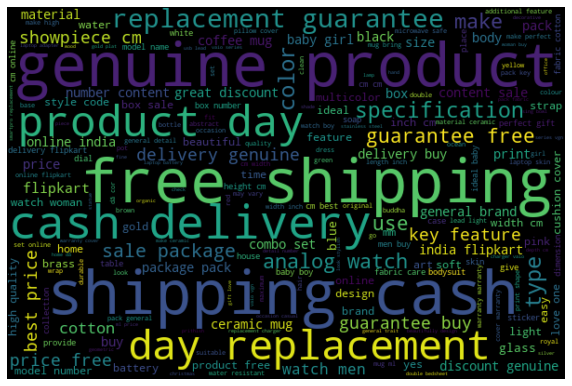


-------------------------
Delete infrequent and too frequent words in progress ...
... finished
---------
---------
Il y a 899 mots différents dans les descriptions.
Sentence example : ['specification', 'palito', 'plo', 'analog', 'watch', 'girl', 'woman', 'general', 'type', 'style', 'code', 'ideal', 'occasion', 'party', 'wedding', 'warranty', 'month', 'body', 'feature', 'dial', 'shape', 'round', 'strap', 'color', 'black']
---------


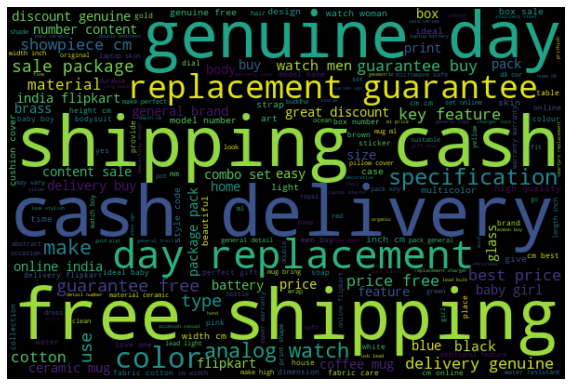

Approche Bag-of-word (cs) :
-------------------------
Nb Features text avant réduction : 899
Réduction TSNE (avec ACP)
Temps de traitement : 17.32723593711853
-------------------------
-------------------------
Delete infrequent and too frequent words in progress ...
... finished
---------
---------
Il y a 899 mots différents dans les descriptions.
Sentence example : ['specification', 'palito', 'plo', 'analog', 'watch', 'girl', 'woman', 'general', 'type', 'style', 'code', 'ideal', 'occasion', 'party', 'wedding', 'warranty', 'month', 'body', 'feature', 'dial', 'shape', 'round', 'strap', 'color', 'black']
---------


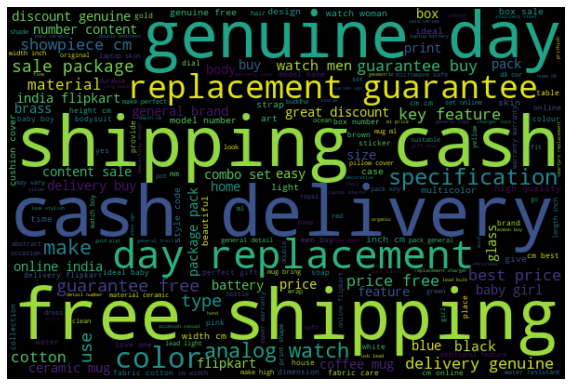

Approche Bag-of-word (tfidf) :
-------------------------
Nb Features text avant réduction : 899
Réduction TSNE (avec ACP)
Temps de traitement : 16.738685369491577
-------------------------
-------------------------
Approche Word/Sentence Embedding (w2v) :
-------------------------
8/8 [==============================] - 2s 28ms/step
Nb Features text avant réduction : 100
Réduction TSNE (sans ACP)
Temps de traitement : 21.85916018486023
-------------------------
-------------------------
Approche Word/Sentence Embedding (bert) :
-------------------------
Nb Features text avant réduction : 768
Réduction TSNE (sans ACP)
Temps de traitement : 167.39639115333557
-------------------------
-------------------------
Approche Word/Sentence Embedding (use) :
-------------------------
Nb Features text avant réduction : 512
Réduction TSNE (sans ACP)
Temps de traitement : 83.33620643615723
-------------------------
-------------------------
Approche (CNN) :
-------------------------
1/1 [===========

1/1 [==============================] - 1s 984ms/step
Nb Features text avant réduction : 4096
Réduction TSNE (avec ACP)
Temps de traitement : 352.8809986114502
-------------------------
-------------------------
Approche (SIFT) :
-------------------------
Nb Features text avant réduction : 351
Réduction TSNE (avec ACP)
Temps de traitement : 4595.569077730179
-------------------------
--------
........
 Approche Features Text :  cs


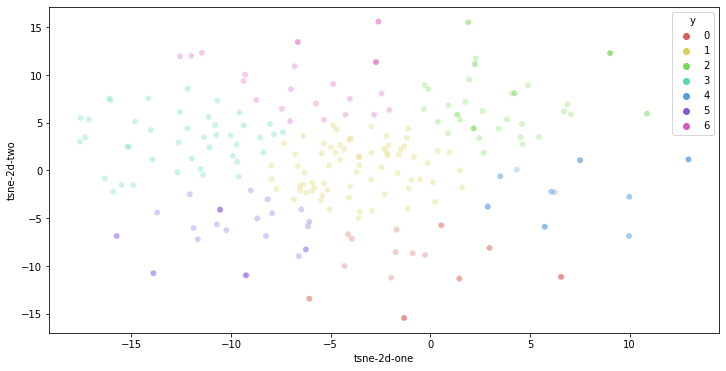

-.-.- Var Desc -.-.-
ARI : 0.1772
Time : 48.0
--------
........
--------
........
 Approche Features Image :  CNN


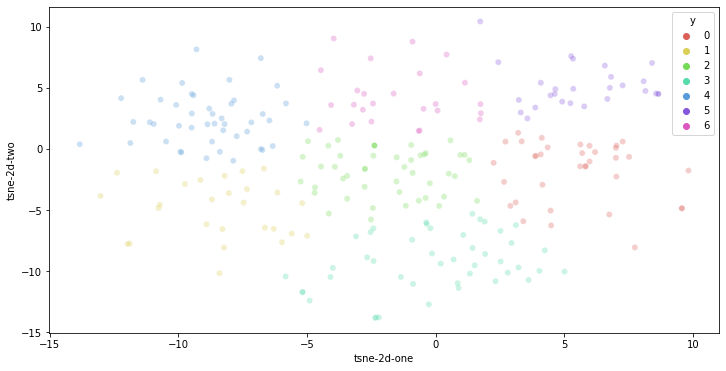

-.-.- Var Image -.-.-
ARI : 0.4435
Time : 361.0
--------
........
--------
........
 Approche Features Texte :  cs
+ Approche Features Image :  CNN


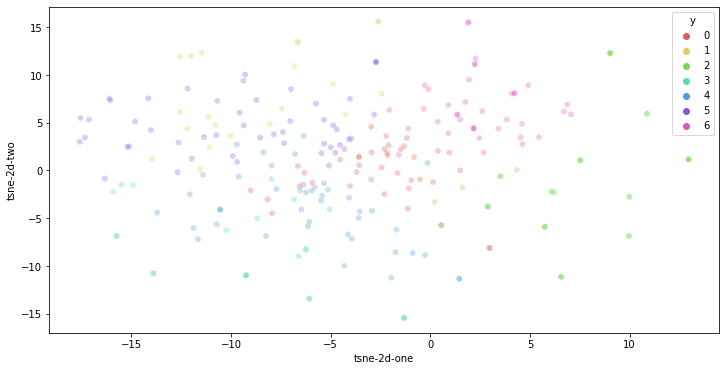

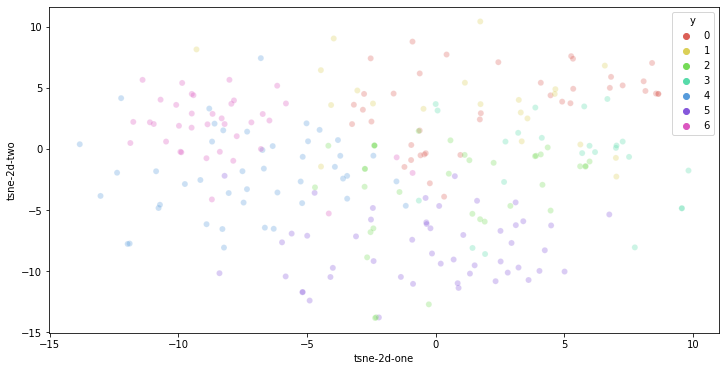

-.-.- Var Desc + Image -.-.-
ARI : 0.2983
Time : 379.0
--------
........
--------
........
 Approche Features Image :  SIFT


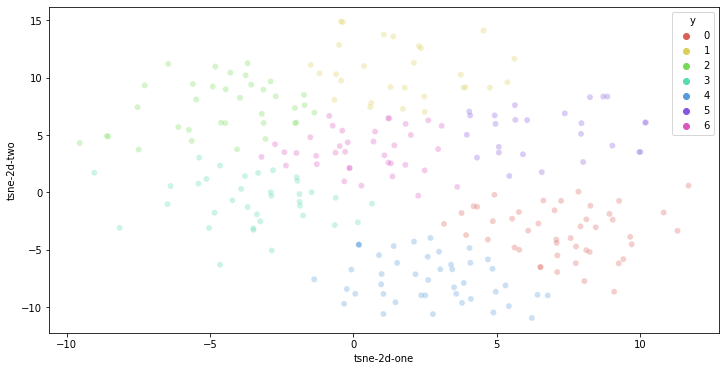

-.-.- Var Image -.-.-
ARI : 0.0319
Time : 4603.0
--------
........
--------
........
 Approche Features Texte :  cs
+ Approche Features Image :  SIFT


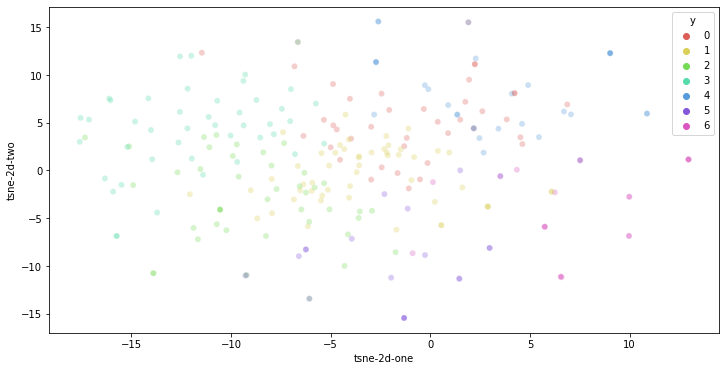

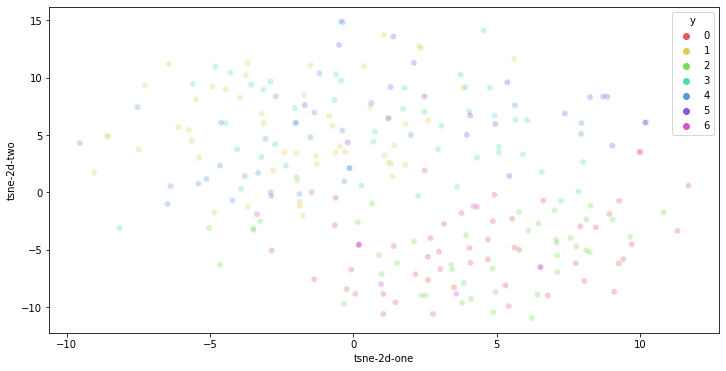

-.-.- Var Desc + Image -.-.-
ARI : 0.0979
Time : 4621.0
--------
........
--------
........
 Approche Features Text :  tfidf


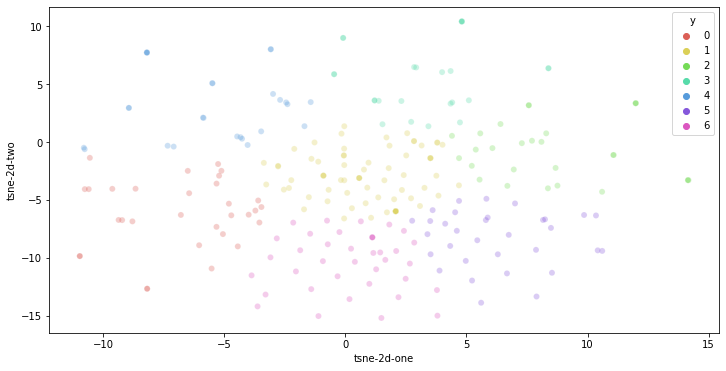

-.-.- Var Desc -.-.-
ARI : 0.0953
Time : 24.0
--------
........
--------
........
 Approche Features Texte :  tfidf
+ Approche Features Image :  CNN


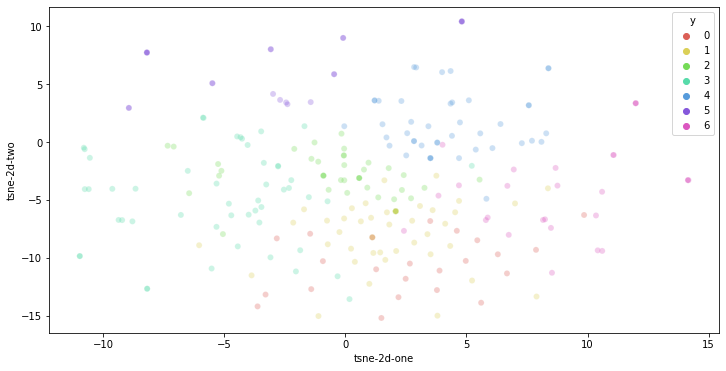

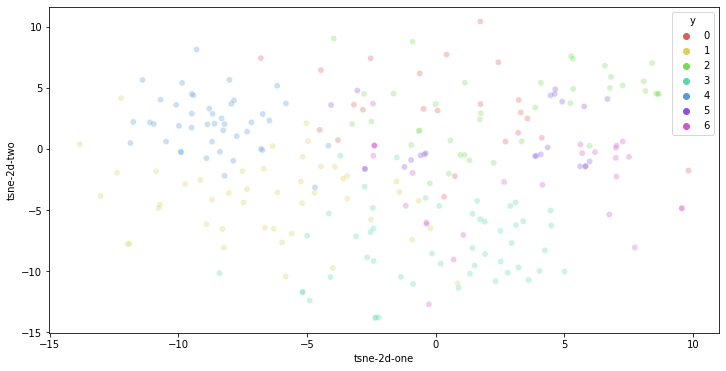

-.-.- Var Desc + Image -.-.-
ARI : 0.3564
Time : 404.0
--------
........
--------
........
 Approche Features Texte :  tfidf
+ Approche Features Image :  SIFT


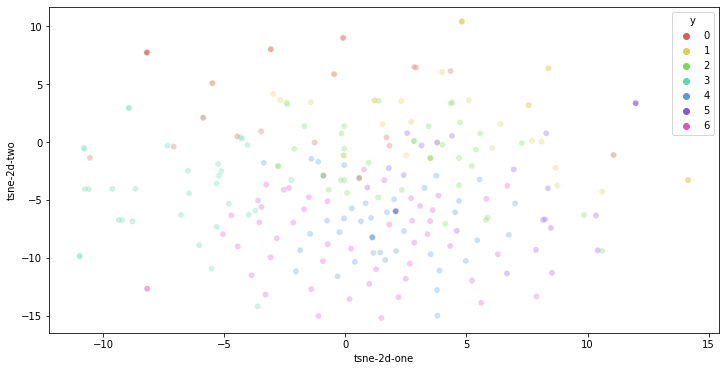

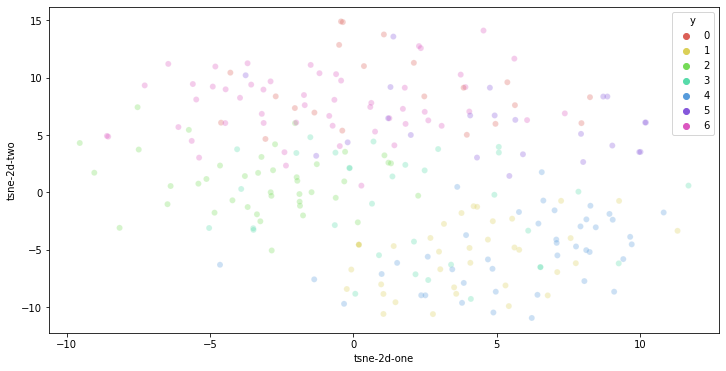

-.-.- Var Desc + Image -.-.-
ARI : 0.0959
Time : 4620.0
--------
........
--------
........
 Approche Features Text :  w2v


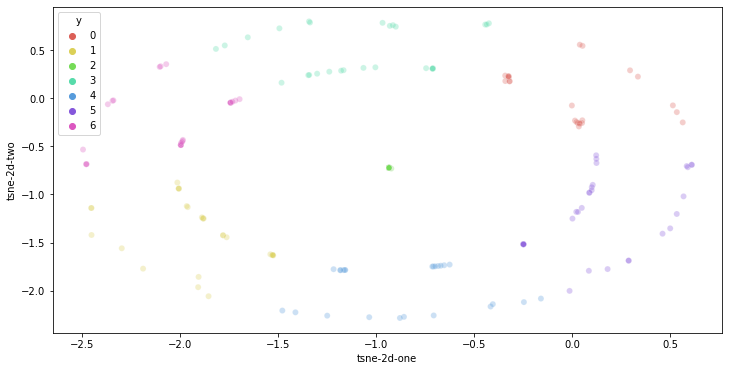

-.-.- Var Desc -.-.-
ARI : 0.0058
Time : 29.0
--------
........
--------
........
 Approche Features Texte :  w2v
+ Approche Features Image :  CNN


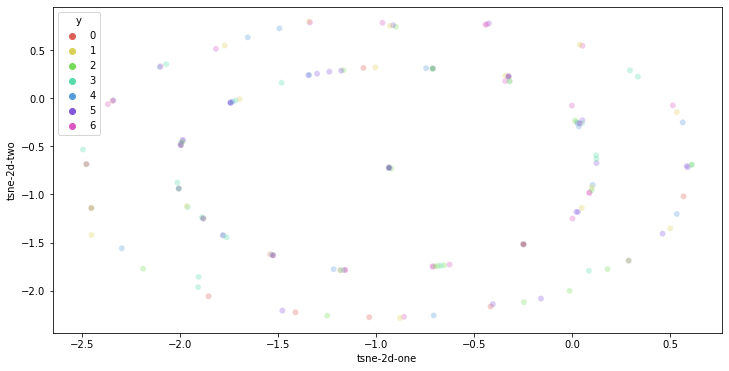

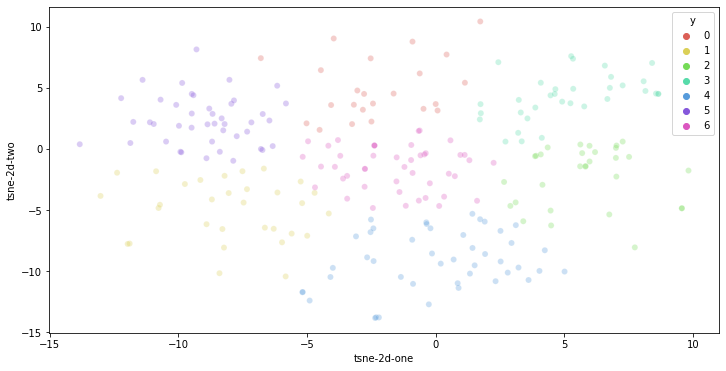

-.-.- Var Desc + Image -.-.-
ARI : 0.4468
Time : 383.0
--------
........
--------
........
 Approche Features Texte :  w2v
+ Approche Features Image :  SIFT


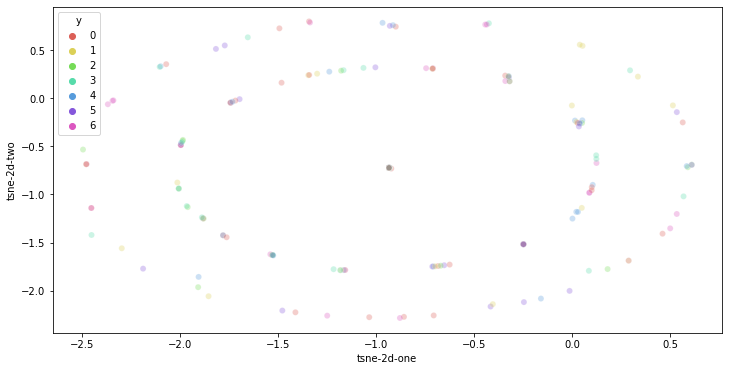

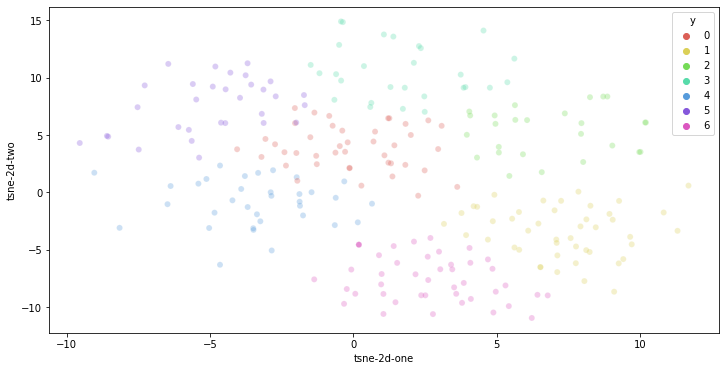

-.-.- Var Desc + Image -.-.-
ARI : 0.0379
Time : 4625.0
--------
........
--------
........
 Approche Features Text :  bert


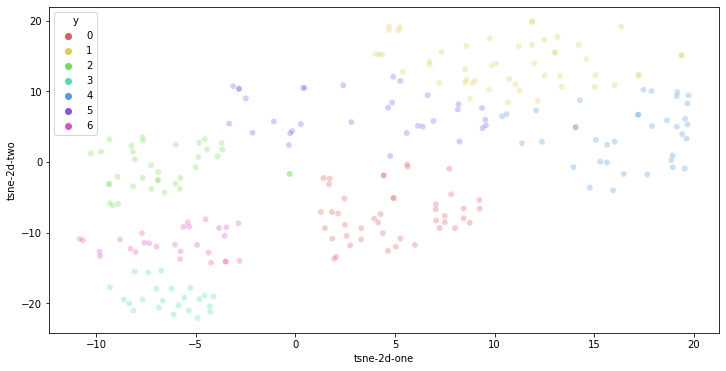

-.-.- Var Desc -.-.-
ARI : 0.2731
Time : 175.0
--------
........
--------
........
 Approche Features Texte :  bert
+ Approche Features Image :  CNN


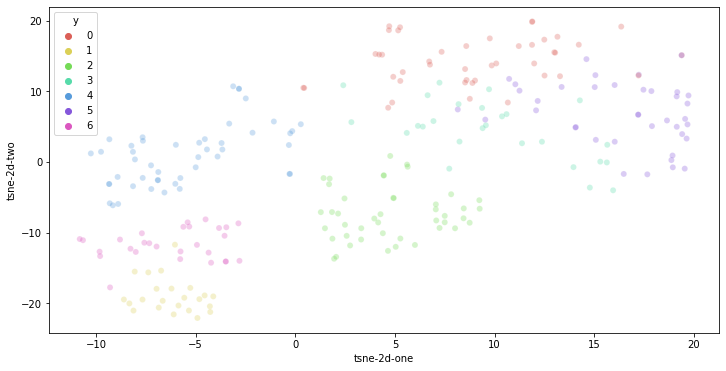

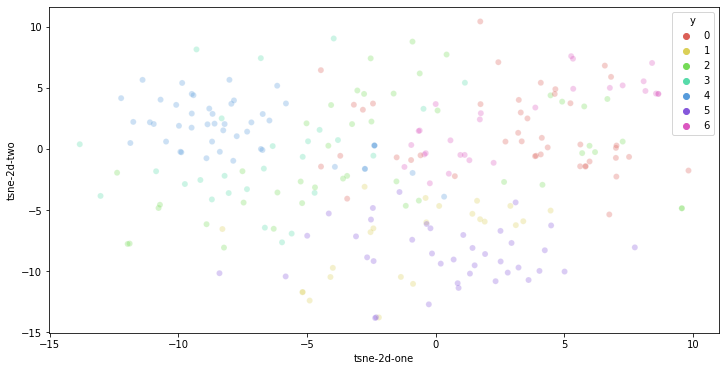

-.-.- Var Desc + Image -.-.-
ARI : 0.3606
Time : 528.0
--------
........
--------
........
 Approche Features Texte :  bert
+ Approche Features Image :  SIFT


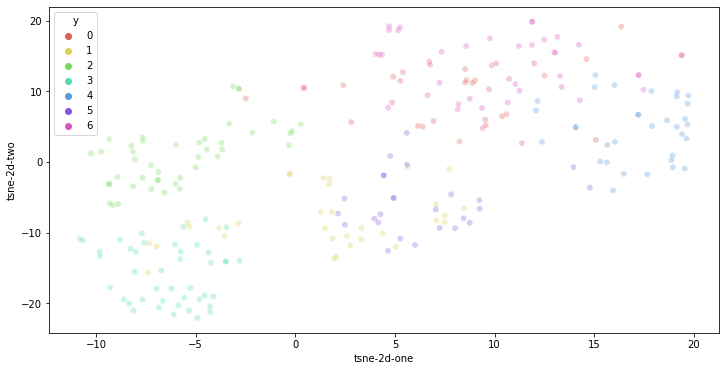

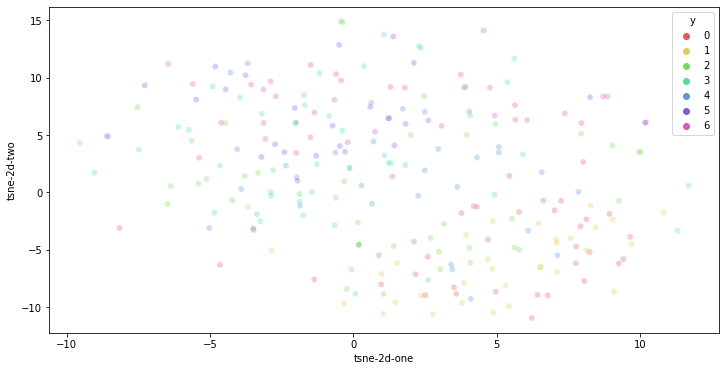

-.-.- Var Desc + Image -.-.-
ARI : 0.2858
Time : 4771.0
--------
........
--------
........
 Approche Features Text :  use


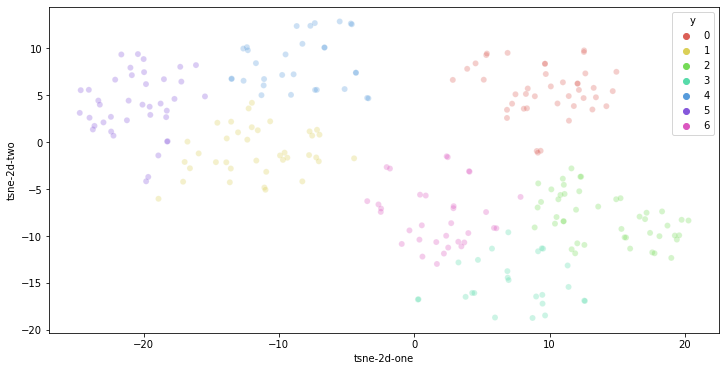

-.-.- Var Desc -.-.-
ARI : 0.3684
Time : 91.0
--------
........
--------
........
 Approche Features Texte :  use
+ Approche Features Image :  CNN


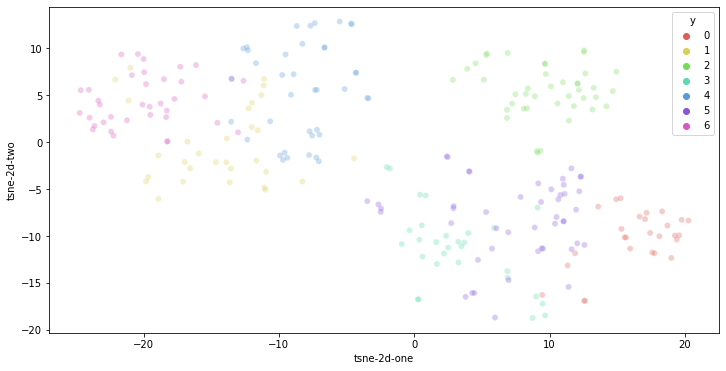

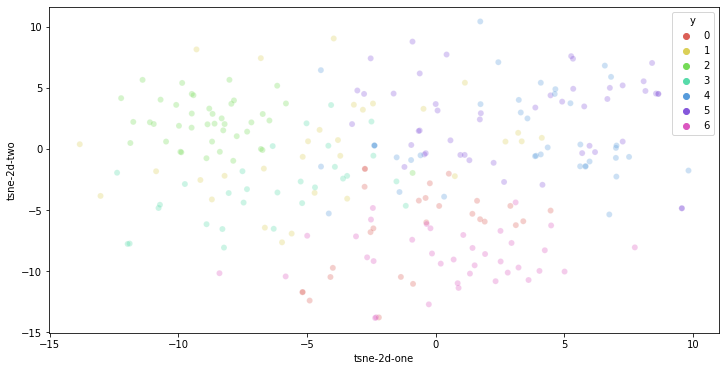

-.-.- Var Desc + Image -.-.-
ARI : 0.3549
Time : 444.0
--------
........
--------
........
 Approche Features Texte :  use
+ Approche Features Image :  SIFT


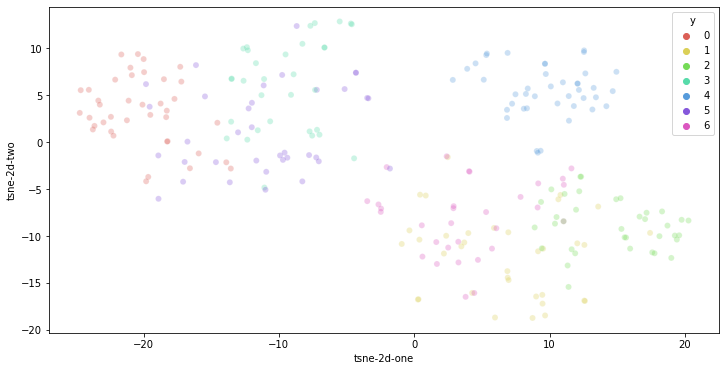

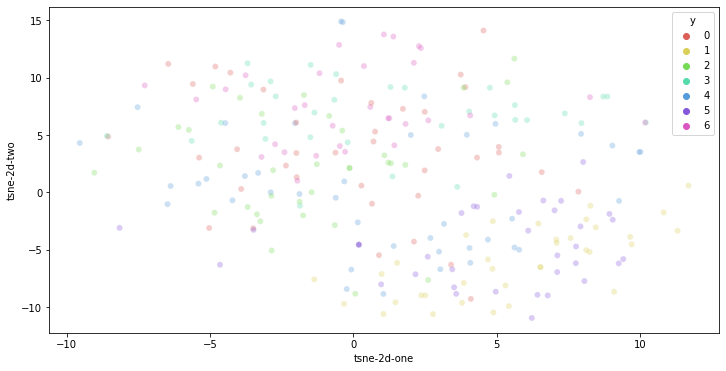

-.-.- Var Desc + Image -.-.-
ARI : 0.295
Time : 4687.0
--------
........


In [41]:
df_res = classif_KMeans(df, path, list_feature_txt, list_feature_pict, n_cat, df_res)

In [42]:
df_res.sort_values('ARI', ascending = False)

,Modèle,Feature Texte,Feature Picture,Reduction,Time,ARI
9,KMeans,w2v,CNN,Features Text sans ACP & Features Images avec ACP,383.0000,0.4468
1,KMeans,NaN,CNN,(avec ACP),361.0000,0.4435
14,KMeans,use,NaN,(sans ACP),91.0000,0.3684
12,KMeans,bert,CNN,Features Text sans ACP & Features Images avec ACP,528.0000,0.3606
6,KMeans,tfidf,CNN,Features Text sans ACP & Features Images avec ACP,404.0000,0.3564
15,KMeans,use,CNN,Features Text sans ACP & Features Images avec ACP,444.0000,0.3549
2,KMeans,cs,CNN,Features Text sans ACP & Features Images avec ACP,379.0000,0.2983
16,KMeans,use,SIFT,Features Text sans ACP & Features Images avec ACP,4687.0000,0.2950
13,KMeans,bert,SIFT,Features Text sans ACP & Features Images avec ACP,4771.0000,0.2858
11,KMeans,bert,NaN,(sans ACP),175.0000,0.2731
